# Contribute Proportional to Trust With Weighted Average Ensemble

A weighted average ensemble is an approach that allows multiple models to contribute to a prediction in proportion to their trust or estimated performance. A modeling averaging ensemble combines the prediction from each model equally and often results in better performance on average than a given single model. Sometimes there are very good models that we wish to contribute more to an ensemble prediction, and perhaps less skillful models that may be useful but should contribute less to an ensemble prediction. In this tutorial, you will discover how to develop a weighted average ensemble of deep learning neural network models in Python with Keras. After completing this tutorial, you will know:

* Model averaging ensembles are limited because they require that each ensemble member contribute equally to predictions.
* Weighted average ensembles allow the contribution of each ensemble member to a prediction to be weighted proportionally to the trust or performance of the member on a holdout dataset.
* How to implement a weighted average ensemble in Keras and compare results to a model averaging ensemble and standalone models.

## Weighted Average Ensemble

Model averaging is an approach to ensemble learning where each ensemble member contributes an equal amount to the final prediction. In the case of regression, the ensemble prediction is calculated as the average of the member predictions. In the case of predicting a class label, the prediction is calculated as the mode of the member predictions. In the case of predicting a class probability, the prediction can be calculated as the argmax of the summed probabilities for each class label. A limitation of this approach is that each model has an equal contribution to the final prediction made by the ensemble. There is a requirement that all ensemble members have the skill compared to random chance, although some models are known to perform much better or much worse than others.

A weighted ensemble is an extension of a model averaging ensemble where the model's performance weights the contribution of each member to the final prediction. The model weights are small positive values, and the sum of all weights equals one, allowing the weights to indicate the percentage of trust or expected performance from each model.

Uniform values for the weights (e.g., $ \frac{1}{k} $ where k is the number of ensemble members) mean that the weighted ensemble acts as a simple averaging ensemble. There is no analytical solution to finding the weights (we cannot calculate them); instead, the value for the weights can be estimated using either the training dataset or a holdout validation dataset. Finding the weights using the same training set used to fit the ensemble members will likely result in an overfit model. A more robust approach is to use a holdout validation dataset unseen by the ensemble members during training.

The simplest, perhaps most exhaustive approach would be to grid search weight values between 0 and 1 for each ensemble member. Alternately, an optimization procedure such as a linear solver or gradient descent optimization can be used to estimate the weights using a unit norm weight constraint to ensure that the vector of weights sum to one. Unless the holdout validation dataset is large and representative, a weighted ensemble can overfit compared to a simple averaging ensemble. A simple alternative to adding more weight to a given model without calculating explicit weight coefficients is to add a given model more than once to the ensemble. Although less flexible, it allows a given well-performing model to contribute more than once to a given prediction made by the ensemble.

## Weighted Average Ensemble Case Study

In this section, we will demonstrate how to use the weighted average ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the weighted average ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate the weighted averaging ensemble. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. The problem can be configured to have two input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same data points.

In [6]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

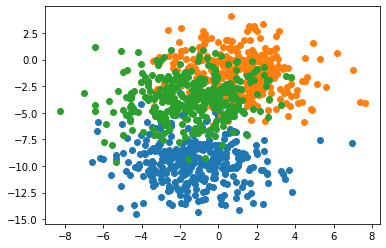

In [7]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance.

### Multilayer Perceptron Model

Before we define a model, we need to contrive an appropriate problem for the weighted average ensemble. In our problem, the training dataset is relatively small. Specifically, there is a 10:1 ratio of examples in the training dataset to the holdout dataset. This mimics a situation where we may have a vast number of unlabeled examples and a small number of labeled examples with which to train a model. We will create 1,100 data points from the blobs problem. The model will be trained on the first 100 points, and the remaining 1,000 will be held back in a test dataset, unavailable to the model.

The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [8]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 25 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and the efficient Adam flavor of stochastic gradient descent.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for 500 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [10]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=1)

Epoch 1/500
4/4 [==============================] - 0s 41ms/step - loss: 1.2123 - accuracy: 0.4326 - val_loss: 1.2347 - val_accuracy: 0.3790
Epoch 2/500
4/4 [==============================] - 0s 17ms/step - loss: 1.1811 - accuracy: 0.4138 - val_loss: 1.2106 - val_accuracy: 0.3810
Epoch 3/500
4/4 [==============================] - 0s 16ms/step - loss: 1.1320 - accuracy: 0.4439 - val_loss: 1.1865 - val_accuracy: 0.3830
Epoch 4/500
4/4 [==============================] - 0s 15ms/step - loss: 1.1023 - accuracy: 0.4470 - val_loss: 1.1629 - val_accuracy: 0.3840
Epoch 5/500
4/4 [==============================] - 0s 16ms/step - loss: 1.1003 - accuracy: 0.4460 - val_loss: 1.1402 - val_accuracy: 0.3840
Epoch 6/500
4/4 [==============================] - 0s 17ms/step - loss: 1.1412 - accuracy: 0.3678 - val_loss: 1.1192 - val_accuracy: 0.3890
Epoch 7/500
4/4 [==============================] - 0s 38ms/step - loss: 1.0636 - accuracy: 0.4199 - val_loss: 1.0999 - val_accuracy: 0.3920
Epoch 8/500
4/4 [===

4/4 [==============================] - 0s 15ms/step - loss: 0.5970 - accuracy: 0.7422 - val_loss: 0.6641 - val_accuracy: 0.6710
Epoch 60/500
4/4 [==============================] - 0s 15ms/step - loss: 0.6099 - accuracy: 0.6984 - val_loss: 0.6614 - val_accuracy: 0.6710
Epoch 61/500
4/4 [==============================] - 0s 37ms/step - loss: 0.5984 - accuracy: 0.7173 - val_loss: 0.6580 - val_accuracy: 0.6750
Epoch 62/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5902 - accuracy: 0.7048 - val_loss: 0.6543 - val_accuracy: 0.6770
Epoch 63/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5954 - accuracy: 0.7359 - val_loss: 0.6513 - val_accuracy: 0.6760
Epoch 64/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5924 - accuracy: 0.7090 - val_loss: 0.6488 - val_accuracy: 0.6760
Epoch 65/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5502 - accuracy: 0.7536 - val_loss: 0.6480 - val_accuracy: 0.6750
Epoch 66/500
4/4 [========

4/4 [==============================] - 0s 15ms/step - loss: 0.5148 - accuracy: 0.7429 - val_loss: 0.5807 - val_accuracy: 0.7290
Epoch 118/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4914 - accuracy: 0.7625 - val_loss: 0.5805 - val_accuracy: 0.7290
Epoch 119/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5331 - accuracy: 0.7271 - val_loss: 0.5789 - val_accuracy: 0.7320
Epoch 120/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5518 - accuracy: 0.7219 - val_loss: 0.5771 - val_accuracy: 0.7340
Epoch 121/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5234 - accuracy: 0.7542 - val_loss: 0.5761 - val_accuracy: 0.7350
Epoch 122/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5124 - accuracy: 0.7479 - val_loss: 0.5751 - val_accuracy: 0.7350
Epoch 123/500
4/4 [==============================] - 0s 15ms/step - loss: 0.5462 - accuracy: 0.7073 - val_loss: 0.5745 - val_accuracy: 0.7360
Epoch 124/500
4/4 [=

Epoch 175/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4618 - accuracy: 0.8190 - val_loss: 0.5353 - val_accuracy: 0.7760
Epoch 176/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4697 - accuracy: 0.7908 - val_loss: 0.5344 - val_accuracy: 0.7800
Epoch 177/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4643 - accuracy: 0.8065 - val_loss: 0.5340 - val_accuracy: 0.7810
Epoch 178/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4637 - accuracy: 0.7960 - val_loss: 0.5350 - val_accuracy: 0.7780
Epoch 179/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4830 - accuracy: 0.7867 - val_loss: 0.5358 - val_accuracy: 0.7740
Epoch 180/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4635 - accuracy: 0.7867 - val_loss: 0.5361 - val_accuracy: 0.7730
Epoch 181/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4285 - accuracy: 0.8221 - val_loss: 0.5354 - val_accuracy: 0.7740
Epoch 

Epoch 233/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4406 - accuracy: 0.7783 - val_loss: 0.5058 - val_accuracy: 0.7960
Epoch 234/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3984 - accuracy: 0.8148 - val_loss: 0.5056 - val_accuracy: 0.7980
Epoch 235/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4545 - accuracy: 0.7804 - val_loss: 0.5055 - val_accuracy: 0.7960
Epoch 236/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4297 - accuracy: 0.7971 - val_loss: 0.5058 - val_accuracy: 0.7950
Epoch 237/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3917 - accuracy: 0.8428 - val_loss: 0.5057 - val_accuracy: 0.7940
Epoch 238/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4055 - accuracy: 0.8146 - val_loss: 0.5049 - val_accuracy: 0.7940
Epoch 239/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4539 - accuracy: 0.7865 - val_loss: 0.5046 - val_accuracy: 0.7940
Epoch 

Epoch 291/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4063 - accuracy: 0.8341 - val_loss: 0.4893 - val_accuracy: 0.7990
Epoch 292/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4001 - accuracy: 0.8525 - val_loss: 0.4910 - val_accuracy: 0.7980
Epoch 293/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3601 - accuracy: 0.8756 - val_loss: 0.4926 - val_accuracy: 0.7930
Epoch 294/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3627 - accuracy: 0.8745 - val_loss: 0.4933 - val_accuracy: 0.7900
Epoch 295/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3730 - accuracy: 0.8620 - val_loss: 0.4921 - val_accuracy: 0.7890
Epoch 296/500
4/4 [==============================] - 0s 17ms/step - loss: 0.3963 - accuracy: 0.8216 - val_loss: 0.4877 - val_accuracy: 0.7950
Epoch 297/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4061 - accuracy: 0.8329 - val_loss: 0.4858 - val_accuracy: 0.7970
Epoch 

Epoch 349/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3942 - accuracy: 0.8009 - val_loss: 0.4763 - val_accuracy: 0.8040
Epoch 350/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4226 - accuracy: 0.7813 - val_loss: 0.4756 - val_accuracy: 0.8040
Epoch 351/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3678 - accuracy: 0.8303 - val_loss: 0.4754 - val_accuracy: 0.8060
Epoch 352/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3600 - accuracy: 0.8157 - val_loss: 0.4748 - val_accuracy: 0.8070
Epoch 353/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3847 - accuracy: 0.8217 - val_loss: 0.4734 - val_accuracy: 0.8030
Epoch 354/500
4/4 [==============================] - 0s 15ms/step - loss: 0.4011 - accuracy: 0.7842 - val_loss: 0.4726 - val_accuracy: 0.8030
Epoch 355/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3793 - accuracy: 0.8082 - val_loss: 0.4723 - val_accuracy: 0.8030
Epoch 

Epoch 407/500
4/4 [==============================] - 0s 17ms/step - loss: 0.3626 - accuracy: 0.8113 - val_loss: 0.4698 - val_accuracy: 0.8040
Epoch 408/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3794 - accuracy: 0.7988 - val_loss: 0.4688 - val_accuracy: 0.8030
Epoch 409/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3479 - accuracy: 0.8216 - val_loss: 0.4686 - val_accuracy: 0.8060
Epoch 410/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3779 - accuracy: 0.8185 - val_loss: 0.4689 - val_accuracy: 0.8060
Epoch 411/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3600 - accuracy: 0.8487 - val_loss: 0.4698 - val_accuracy: 0.8040
Epoch 412/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3436 - accuracy: 0.8435 - val_loss: 0.4709 - val_accuracy: 0.8040
Epoch 413/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3864 - accuracy: 0.8185 - val_loss: 0.4717 - val_accuracy: 0.8000
Epoch 

Epoch 465/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3302 - accuracy: 0.8558 - val_loss: 0.4740 - val_accuracy: 0.8010
Epoch 466/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3214 - accuracy: 0.8620 - val_loss: 0.4742 - val_accuracy: 0.8010
Epoch 467/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3271 - accuracy: 0.8414 - val_loss: 0.4745 - val_accuracy: 0.8010
Epoch 468/500
4/4 [==============================] - 0s 17ms/step - loss: 0.3548 - accuracy: 0.8164 - val_loss: 0.4742 - val_accuracy: 0.7990
Epoch 469/500
4/4 [==============================] - 0s 16ms/step - loss: 0.3605 - accuracy: 0.8257 - val_loss: 0.4730 - val_accuracy: 0.8020
Epoch 470/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3753 - accuracy: 0.8060 - val_loss: 0.4722 - val_accuracy: 0.8020
Epoch 471/500
4/4 [==============================] - 0s 15ms/step - loss: 0.3575 - accuracy: 0.8153 - val_loss: 0.4715 - val_accuracy: 0.8060
Epoch 

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [11]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.840, Test: 0.805


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

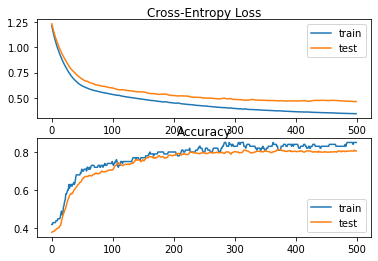

In [12]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [13]:
# fit high variance mlp on blobs classification problem
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# one hot encode output variable
y = to_categorical(y)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

#define model
model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.840, Test: 0.813


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 85% accuracy on the training dataset, which we know is optimistic, and about 80% on the test dataset, which we would expect to be more realistic.

A line plot also shows the learning curves for the model loss and accuracy on the train and test sets over each training epoch. We can see that training accuracy is more optimistic over most of the run, as we noted with the final scores.

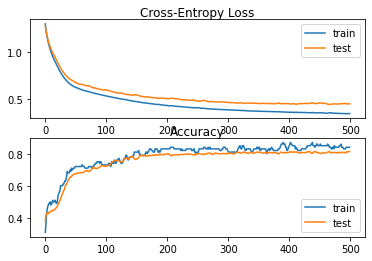

In [14]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

Now that we have identified that the model is a good candidate for developing an ensemble, we can next look at developing a simple model averaging ensemble.

### Model Averaging Ensemble

We can develop a simple model averaging ensemble before developing a weighted average ensemble (covered in depth in Chapter 20). The results of the model averaging ensemble can be used as a point of comparison as we would expect a well-configured weighted average ensemble to perform better. First, we need to fit multiple models from which to develop an ensemble. We will define a function named `fit_model()` to create and fit a single model on the training dataset that we can repeatedly call to create as many models as we wish.

In [15]:
# fit model on dataset
def fit_model(trainX, trainy):
    trainy_enc = to_categorical(trainy)
    
    # define model
    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy_enc, epochs=500, verbose=0)

    return model

We can call this function to create a pool of 10 models.

In [16]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# fit all models
n_members = 10
members = [fit_model(trainX, trainy) for _ in range(n_members)]

Next, we can develop a model averaging ensemble. We don't know how many members would be appropriate for this problem, so we can create ensembles with different sizes from one to 10 members and evaluate the performance of each on the test set. We can also evaluate the performance of each standalone model in the performance on the test set. This provides a useful point of comparison for the model averaging ensemble, as we expect that the ensemble will out-perform a randomly selected single model on average.

Each model predicts the probabilities for each class label, e.g., has three outputs. A single prediction can be converted to a class label by using the `argmax()` function on the predicted probabilities, e.g., return the index in the prediction with the largest probability value. We can ensemble the predictions from multiple models by summing the probabilities for each class prediction and using the argmax() on the result. The ensemble predictions() function below implements this behavior.

In [17]:
# make an ensemble prediction for multiclass classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)

    # argmax across classes

    result = argmax(summed, axis=1)

    return result

We can estimate the performance of an ensemble of a given size by selecting the required number of models from the list of all models, calling the `ensemble_predictions()` function to make a prediction, then calculating the accuracy of the prediction by comparing it to the true
values. The `evaluate_n_members()` function below implements this behavior.

In [18]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]

    # make prediction
    yhat = ensemble_predictions(subset, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

The scores of the ensembles of each size can be stored to be plotted later, and the scores for each model are collected, and the average performance reported.

In [19]:
from sklearn.metrics import accuracy_score
from numpy import array, argmax, mean, std
import numpy

# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()

for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, testX, testy)

    # evaluate the i'th model standalone
    testy_enc = to_categorical(testy)
    _, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)

    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

> 1: single=0.807, ensemble=0.807
> 2: single=0.817, ensemble=0.814
> 3: single=0.814, ensemble=0.812
> 4: single=0.809, ensemble=0.813
> 5: single=0.803, ensemble=0.817
> 6: single=0.808, ensemble=0.817
> 7: single=0.818, ensemble=0.817
> 8: single=0.804, ensemble=0.816
> 9: single=0.811, ensemble=0.815
> 10: single=0.817, ensemble=0.814
Accuracy 0.811 (0.005)


Finally, we create a graph that shows the accuracy of each model (blue dots) and the performance of the model averaging ensemble as the number of members is increased from one to 10 members (orange line). Tying all of this together, the complete example is listed below.

In [20]:
# model averaging ensemble for the blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from numpy import mean, std
from numpy import array, argmax
import numpy

from matplotlib import pyplot

# fit model on dataset
def fit_model(trainX, trainy):
    trainy_enc = to_categorical(trainy)

    # define model
    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy_enc, epochs=500, verbose=0)

    return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)

    # argmax across classes
    result = argmax(summed, axis=1)

    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]

    # make prediction
    yhat = ensemble_predictions(subset, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# fit all models
n_members = 10
members = [fit_model(trainX, trainy) for _ in range(n_members)]

# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, testX, testy)

    # evaluate the i'th model standalone
    testy_enc = to_categorical(testy)
    _, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)

    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)

# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

> 1: single=0.810, ensemble=0.810
> 2: single=0.812, ensemble=0.805
> 3: single=0.804, ensemble=0.812
> 4: single=0.823, ensemble=0.819
> 5: single=0.810, ensemble=0.818
> 6: single=0.798, ensemble=0.814
> 7: single=0.800, ensemble=0.811
> 8: single=0.805, ensemble=0.811
> 9: single=0.802, ensemble=0.812
> 10: single=0.815, ensemble=0.814
Accuracy 0.808 (0.007)


Running the example first reports the performance of every single model and the model averaging ensemble of a given size with 1, 2, 3, etc., members.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

On this run, the average performance of the single models is reported at about 80.4%, and we can see that an ensemble with between five and nine members will achieve a performance between 80.8% and 81%. As expected, the performance of a modest-sized model averaging ensemble out-performs the performance of a randomly selected single model on average.

Next, a graph compares the accuracy of single models (blue dots) to the model averaging ensemble of increasing size (orange line). On this run, the orange line of the ensembles clearly shows better or comparable performance (if dots are hidden) than the single models.

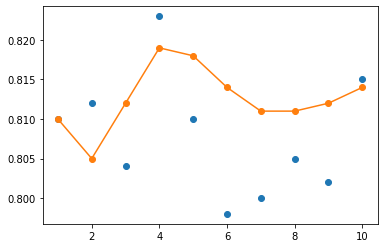

In [21]:
# plot score vs number of ensemble members
x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

Now that we know how to develop a model averaging ensemble, we can extend the approach one step further by weighting the contributions of the ensemble members.

### Grid Search Weighted Average Ensemble

The model averaging ensemble allows each ensemble member to contribute an equal amount to the prediction of the ensemble. We can update the example so that instead, the contribution of each ensemble member is weighted by a coefficient that indicates the trust or expected performance of the model. Weight values are small values between 0 and 1 and are treated as a percentage, such that the weights across all ensemble members sum to one. First, we must update the `ensemble_predictions()` function to use a vector of weights for each ensemble member. Instead of simply summing the predictions across each ensemble member, we must calculate a weighted sum. We can implement this manually using for loops, but this is inefficient; for example:

In [22]:
# calculated a weighted sum of predictions
def weighted_sum(weights, yhats):
    rows = list()
    for j in range(yhats.shape[1]):
        # enumerate values
        row = list()
        
        for k in range(yhats.shape[2]):
            # enumerate members
            value = 0.0
            for i in range(yhats.shape[0]):
                value += weights[i] * yhats[i,j,k]
            row.append(value)
        rows.append(row)
    return array(rows)

Instead, we can use efficient NumPy functions to implement the weighted sum such as `einsum()` or `tensordot().` Full discussion of these functions is a little out of scope, so please refer to the API documentation for more information on how to use these functions as they are challenging if you are new to linear algebra and/or NumPy. We will use the `tensordot()` function to apply the tensor product with the required summing; the updated `ensemble_predictions()` function is listed below.

In [23]:
from numpy import tensordot

# make an ensemble prediction for multiclass classification
def ensemble_predictions(members, weights, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # weighted sum across ensemble members
    summed = tensordot(yhats, weights, axes=((0),(0)))

    # argmax across classes
    result = argmax(summed, axis=1)

    return result

Next, we must update `evaluate_ensemble()` to pass along the weights when predicting the ensemble.

In [24]:
# evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
    # make prediction
    yhat = ensemble_predictions(members, weights, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

We will use a modest-sized ensemble of five members that appeared to perform well in the model averaging ensemble.

In [25]:
# fit all models
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]

We can then estimate the performance of each model on the test dataset as a reference.

In [26]:
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)

Equal Weights Score: 0.818


Finally, we can develop a weighted average ensemble. An exhaustive but straightforward approach to finding weights for the ensemble members is to grid search values. We can define a course grid of weight values from 0.0 to 1.0 in steps of 0.1, then generate all possible five-element vectors
with those values. Generating all possible combinations is called a Cartesian product, which can be implemented in Python using the `itertools.product()` function from the standard library.

A limitation of this approach is that the vectors of weights will not sum to one (called the unit norm), as required. We can force each generated weight vector to have a unit norm by calculating the sum of the absolute weight values (the L1 norm) and dividing each weight by that value. The `normalize()` function below implements this hack.

In [27]:
# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = norm(weights, 1)

    # check for a vector of all zeros
    if result == 0.0:
        return weights

    # return normalized vector (unit norm)
    return weights / result

We can now enumerate each weight vector generated by the Cartesian product, normalize it, and evaluate it by making a prediction and keeping the best to be used in our final weight averaging ensemble.

In [28]:
# grid search weights
def grid_search(members, testX, testy):
    # define weights to consider
    w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    best_score, best_weights = 0.0, None
    
    # iterate all possible combinations (cartesian product)
    for weights in product(w, repeat=len(members)):
        # skip if all weights are equal
        if len(set(weights)) == 1:
            continue
        
        # hack, normalize weight vector
        weights = normalize(weights)

        # evaluate weights
        score = evaluate_ensemble(members, weights, testX, testy)
        if score > best_score:
            best_score, best_weights = score, weights
            print('>%s %.3f' % (best_weights, best_score))
    
    return list(best_weights)

Once discovered, we can report the performance of our weight average ensemble on the test dataset, which we would expect to be better than the best single model and ideally better than the model averaging ensemble.

In [ ]:
from numpy.linalg import norm
from itertools import product

# grid search weights
weights = grid_search(members, testX, testy)
score = evaluate_ensemble(members, weights, testX, testy)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

The complete example is listed below.

In [29]:
# grid search for coefficients in a weighted average ensemble for the blobs problem
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from numpy import array, argmax, tensordot
from numpy.linalg import norm
from itertools import product

# fit model on dataset
def fit_model(trainX, trainy):
    trainy_enc = to_categorical(trainy)

    # define model
    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy_enc, epochs=500, verbose=0)

    return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # weighted sum across ensemble members
    summed = tensordot(yhats, weights, axes=((0),(0)))

    # argmax across classes
    result = argmax(summed, axis=1)
    
    return result

# evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
    # make prediction
    yhat = ensemble_predictions(members, weights, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = norm(weights, 1)

    # check for a vector of all zeros
    if result == 0.0:
        return weights

    # return normalized vector (unit norm)
    return weights / result

# grid search weights
def grid_search(members, testX, testy):
    # define weights to consider
    w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    best_score, best_weights = 0.0, None

    # iterate all possible combinations (cartesian product)
    for weights in product(w, repeat=len(members)):
        
        # skip if all weights are equal
        if len(set(weights)) == 1:
            continue

        # hack, normalize weight vector
        weights = normalize(weights)

        # evaluate weights
        score = evaluate_ensemble(members, weights, testX, testy)

        if score > best_score:
            best_score, best_weights = score, weights
            print('>%s %.3f' % (best_weights, best_score))
    
    return list(best_weights)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# fit all models
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]

Model 1: 0.818
Model 2: 0.801
Model 3: 0.810
Model 4: 0.812
Model 5: 0.805


Running the example first creates the five single models and evaluates their performance on the test dataset.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

We can see that model 2 has the best solo performance of about 81.7% accuracy on this run. Next, a model averaging ensemble is created with a performance of approximately 80.7%, which is reasonable compared to most of the models, but not all.

In [31]:
# evaluate each single model on the test set
testy_enc = to_categorical(testy)
for i in range(n_members):
    _, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
    print('Model %d: %.3f' % (i+1, test_acc))

# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)

Model 1: 0.818
Model 2: 0.801
Model 3: 0.810
Model 4: 0.812
Model 5: 0.805
Equal Weights Score: 0.812


Next, the grid search is performed. It is pretty slow and may take about twenty minutes on modern hardware. The process could easily be made parallel using libraries such as Joblib. Each time a new top-performing set of weights is discovered, it is reported along with its performance on the test dataset. During the run, we can see that the process discovered that using model 2 alone resulted in a good performance until it was replaced with something better. We can see that the best performance was achieved on this run using the weights that focus only on the first and second models with an accuracy of 81.8% on the test dataset. This out-performs both the single models and the model averaging ensemble on the same dataset.

In [ ]:
# grid search weights
weights = grid_search(members, testX, testy)
score = evaluate_ensemble(members, weights, testX, testy)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

An alternate approach to finding weights would be a random search, which is more effective generally for model hyperparameter tuning.

### Weighted Average MLP Ensemble

An alternative to searching for weight values is to use a directed optimization process. Optimization is a search process, but instead of sampling the space of possible solutions randomly or exhaustively, the search process uses any available information to make the next step in the search, such as toward a set of weights with lower error. The SciPy library offers many excellent optimization algorithms, including local and global search methods.

SciPy provides an implementation of the Differential Evolution method. This is one of the few stochastic global search algorithms that just works for function optimization with continuous inputs, and it works well. The `differential_evolution()` SciPy function requires that function is specified to evaluate a set of weights and return a score to be minimized. We can minimize the classification error (1 - accuracy). As with the grid search, we most normalize the weight vector before we evaluate it. The loss function() function below will be used as the evaluation function during the optimization process.

In [1]:
# loss function for optimization process, designed to be minimized
def loss_function(weights, members, testX, testy):
    # normalize weights
    normalized = normalize(weights)
    
    # calculate error rate
    return 1.0 - evaluate_ensemble(members, normalized, testX, testy)

We must also specify the bounds of the optimization process. We can define the bounds as a five-dimensional hypercube (e.g., five weights for the five ensemble members) with values between 0.0 and 1.0.

```
# define bounds on each weight
bound_w = [(0.0, 1.0) for _ in range(n_members)]
```

Our loss function requires three parameters in addition to the weights, which we will provide as a tuple to then be passed along to the call to the `loss_function()` each time a set of weights is evaluated.

```
# arguments to the loss function
search_arg = (members, testX, testy)
```

We can now call our optimization process. We will limit the total number of iterations of the algorithms to 1,000 and use a smaller than default tolerance to detect if the search process has converged.

```
# global optimization of ensemble weights
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)
```

The result of the call to `differential_evolution()` is a dictionary that contains all kinds of information about the search. Importantly, the x key contains the optimal set of weights found during the search. We can retrieve the best set of weights, then report them and their performance on the test set when used in a weighted ensemble.

```
# get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)

# evaluate chosen weights
score = evaluate_ensemble(members, weights, testX, testy)
print('Optimized Weights Score: %.3f' % score)
```

Tying all of this together, the complete example is listed below.

In [10]:
# global optimization to find coefficients for weighted ensemble on blobs problem
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from numpy import array, argmax, tensordot
from numpy.linalg import norm
from scipy.optimize import differential_evolution

# fit model on dataset
def fit_model(trainX, trainy):
    trainy_enc = to_categorical(trainy)
    
    # define model
    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy_enc, epochs=500, verbose=0)

    return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # weighted sum across ensemble members
    summed = tensordot(yhats, weights, axes=((0),(0)))

    # argmax across classes
    result = argmax(summed, axis=1)
    
    return result

# evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
    # make prediction
    yhat = ensemble_predictions(members, weights, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = norm(weights, 1)

    # check for a vector of all zeros
    if result == 0.0:
        return weights

    # return normalized vector (unit norm)
    return weights / result

# loss function for optimization process, designed to be minimized
def loss_function(weights, members, testX, testy):
    # normalize weights
    normalized = normalize(weights)

    # calculate error rate
    return 1.0 - evaluate_ensemble(members, normalized, testX, testy)

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# fit all models
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]

Running the example first creates five single models and evaluates the performance of each on the test dataset.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

We can see on this run that models 3 and 4 both perform best with an accuracy of about 82.2%. Next, a model averaging ensemble with all five members is evaluated on the test set, reporting an accuracy of 81.8%, which is better than some, but not all, single models.

In [11]:
# evaluate each single model on the test set
testy_enc = to_categorical(testy)
for i in range(n_members):
    _, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
    print('Model %d: %.3f' % (i+1, test_acc))

# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)

Model 1: 0.810
Model 2: 0.816
Model 3: 0.810
Model 4: 0.815
Model 5: 0.815
Equal Weights Score: 0.816


The optimization process is relatively quick. We can see that the process found a set of weights that pays most attention to models 3 and 4 and spreads the remaining attention out among the other models, achieving an accuracy of about 82.4%, out-performing the model averaging ensemble and individual models.

In [12]:
# define bounds on each weight
bound_w = [(0.0, 1.0) for _ in range(n_members)]

# arguments to the loss function
search_arg = (members, testX, testy)

# global optimization of ensemble weights
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)

# get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)

# evaluate chosen weights
score = evaluate_ensemble(members, weights, testX, testy)
print('Optimized Weights Score: %.3f' % score)

Optimized Weights: [0.26649152 0.09657973 0.0100151  0.35467773 0.27223591]
Optimized Weights Score: 0.820


It is important to note that we have treated the test dataset as though it were a validation dataset in these examples, and this was done to keep the examples focused and technically simpler. In practice, the ensemble's choice and tuning of the weights would be chosen by a validation dataset, and single models, model averaging ensembles, and weighted ensembles would be compared on a separate test set.

## Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.

* **Parallelize Grid Search**. Update the grid search example to use the Joblib library to parallelize weight evaluation.
* **Implement Random Search**. Update the grid search example to use a random search of weight coefficients.
* **Try a Local Search**. Try a local search procedure provided by the SciPy library instead of the global search and compare performance.
* **Repeat Global Optimization**. Repeat the global optimization procedure multiple times for a given set of models to see if differing sets of weights can be found across the runs.

## Summary

In this tutorial, you discovered how to develop a weighted average ensemble of deep learning neural network models in Python with Keras. Specifically, you learned:

* Model averaging ensembles are limited because they require that each ensemble member contribute equally to predictions.
* Weighted average ensembles allow the contribution of each ensemble member to a prediction to be weighted proportionally to the trust or performance of the member on a holdout dataset.
* How to implement a weighted average ensemble in Keras and compare results to a model averaging ensemble and standalone models.